In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from collections import defaultdict
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
%config InlineBackend.figure_formats = ['svg']

project_dir = os.path.expanduser('~/RL_2024/')

In [2]:
nS = 750
nA = 25

nS_term = 2
S_survival = 750
S_death = 751

nS_total = nS + nS_term

In [3]:
# Create the reward matrix
R = np.zeros((nS_total, nA, nS_total))

# Set the rewards for terminal states
R[:, :, S_survival] = 1
R[:, :, S_death] = -1

In [4]:
def make_transition_matrix(df_data):
    """
    Create the empirical transition matrix from the dataset.
    """
    # count occurrences of each transition
    SAS_count = df_data.groupby(['s:state', 'a:action', 's:next_state']).size().reset_index(name='count')

    # Create the transition matrix
    P = np.full((nS_total, nA, nS_total), np.nan)
    for i, row in SAS_count.iterrows():
        P[row['s:state'], row['a:action'], row['s:next_state']] = row['count']

    # Normalize the transition matrix
    P = P / np.nansum(P, axis=2, keepdims=True)

    # Set the transition probabilities for terminal states
    P[S_survival, :, :] = 0
    P[S_survival, :, S_survival] = 1
    P[S_death, :, :] = 0
    P[S_death, :, S_death] = 1

    return P

def make_gymP(P, R):
    """
    Convert the transition and reward matrices to the gym format.
    """
    gymP = defaultdict(lambda: defaultdict(list))
    for s in range(nS):
        for a in range(nA):
            for s_ in range(nS_total):
                if not np.isnan(P[s, a, s_]):
                    prob = P[s, a, s_]
                    reward = R[s, a, s_]
                    done = int(s_ in [S_survival, S_death])
                    gymP[s][a].append((prob, s_, reward, done))
    return gymP

In [5]:
df_train_orig = pd.read_csv(project_dir + 'data/trajectory_data/traj_orig_train.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
df_train_dropped = pd.read_csv(project_dir + 'data/trajectory_data/traj_dropped_train.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
df_train_shifted = pd.read_csv(project_dir + 'data/trajectory_data/traj_shifted_train.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})

In [27]:
P_orig = make_transition_matrix(df_train_orig)
P_dropped = make_transition_matrix(df_train_dropped)
P_shifted = make_transition_matrix(df_train_shifted)

In [ ]:
# save the transition matrices
np.save(project_dir + 'data/env_model/P_orig.npy', P_orig)
np.save(project_dir + 'data/env_model/P_dropped.npy', P_dropped)
np.save(project_dir + 'data/env_model/P_shifted.npy', P_shifted)

In [ ]:
# save the reward matrix
np.save(project_dir + 'data/env_model/R.npy', R)
# save the transition matrices in a compressed format
np.savez_compressed(project_dir + 'data/env_model/P.npz', P_orig=P_orig, P_dropped=P_dropped, P_shifted=P_shifted)

In [78]:
gymP_orig = make_gymP(P_orig, R)
gymP_dropped = make_gymP(P_dropped, R)
gymP_shifted = make_gymP(P_shifted, R)

In [82]:
# save the gymP dictionaries
with open(project_dir + 'data/env_model/gymP_orig.pkl', 'wb') as f:
    pickle.dump(dict(gymP_orig), f)
with open(project_dir + 'data/env_model/gymP_dropped.pkl', 'wb') as f:
    pickle.dump(dict(gymP_dropped), f)
with open(project_dir + 'data/env_model/gymP_shifted.pkl', 'wb') as f:
    pickle.dump(dict(gymP_shifted), f)

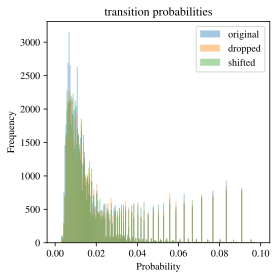

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
plt.hist(P_orig.flatten(), bins=np.arange(0.001, 0.1, 0.0005), alpha=0.4, label='original', fc='tab:blue')
plt.hist(P_dropped.flatten(), bins=np.arange(0.001, 0.1, 0.0005), alpha=0.4, label='dropped', fc='tab:orange')
plt.hist(P_shifted.flatten(), bins=np.arange(0.001, 0.1, 0.0005), alpha=0.4, label='shifted', fc='tab:green')
plt.legend()
plt.title('transition probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

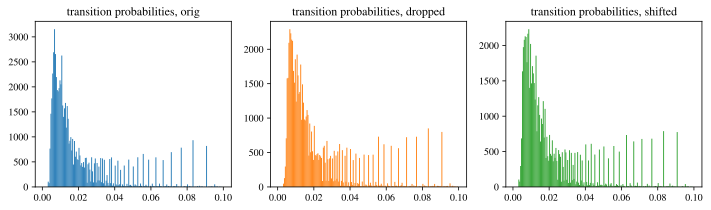

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

plt.sca(ax[0])
plt.hist(P_orig.flatten(), bins=np.arange(0.001, 0.1, 0.0005), fc='tab:blue')
plt.title('transition probabilities, orig')

plt.sca(ax[1])
plt.hist(P_dropped.flatten(), bins=np.arange(0.001, 0.1, 0.0005), fc='tab:orange')
plt.title('transition probabilities, dropped')

plt.sca(ax[2])
plt.hist(P_shifted.flatten(), bins=np.arange(0.001, 0.1, 0.0005), fc='tab:green')
plt.title('transition probabilities, shifted')

plt.show()

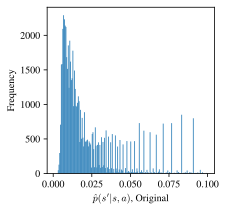

In [46]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.hist(P_dropped.flatten(), bins=np.arange(0.001, 0.1, 0.0005), fc='tab:blue')
plt.xlabel("$\hat{p}(s'|s,a)$, Original")
plt.ylabel('Frequency')
plt.savefig(project_dir + 'figures/transition_probabilities_dropped.pdf', bbox_inches='tight')
plt.show()

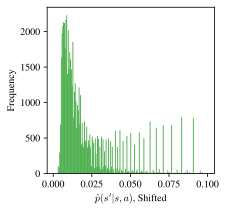

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.hist(P_shifted.flatten(), bins=np.arange(0.001, 0.1, 0.0005), fc='tab:green')
plt.xlabel("$\hat{p}(s'|s,a)$, Shifted")
plt.ylabel('Frequency')
plt.savefig(project_dir + 'figures/transition_probabilities_shifted.pdf', bbox_inches='tight')
plt.show()

In [32]:
P_dropped_ = P_dropped.copy()
P_shifted_ = P_shifted.copy()
P_dropped_[np.isnan(P_dropped_)] = 0
P_shifted_[np.isnan(P_shifted_)] = 0

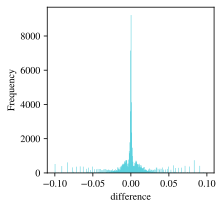

In [33]:
fig, ax = plt.subplots(figsize=(3, 3))
P_diff = P_dropped_ - P_shifted_
P_diff[P_diff == 0] = np.nan
plt.hist(P_diff.flatten(), bins=np.arange(-0.1, 0.1, 0.0005), fc='tab:cyan')
plt.xlabel("difference")
plt.ylabel('Frequency')
plt.savefig(project_dir + 'figures/transition_probabilities_DIFF.pdf', bbox_inches='tight')
plt.show()

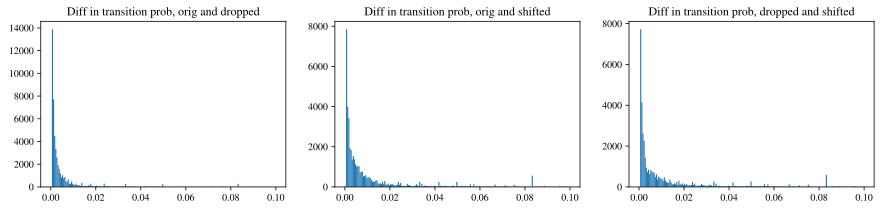

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
plt.sca(ax[0])
plt.hist(np.abs(P_orig-P_dropped).flatten(), bins=np.arange(0.0005, 0.1, 0.0005))
plt.title('Diff in transition prob, orig and dropped')

plt.sca(ax[1])
plt.hist(np.abs(P_orig-P_shifted).flatten(), bins=np.arange(0.0005, 0.1, 0.0005))
plt.title('Diff in transition prob, orig and shifted')

plt.sca(ax[2])
plt.hist(np.abs(P_dropped-P_shifted).flatten(), bins=np.arange(0.0005, 0.1, 0.0005))
plt.title('Diff in transition prob, dropped and shifted')

plt.show()

In [34]:
def tvd(P1, P2):
    """
    Compute the total variation distance between two transition matrices.
    """
    return np.sum(np.abs(P1 - P2)) / 2

In [41]:
sa_tvd = [tvd(P_dropped_[s,a], P_shifted_[s,a]) for s in range(nS) for a in range(nA)]
np.mean(sa_tvd), np.median(sa_tvd), np.percentile(sa_tvd, 25), np.percentile(sa_tvd, 75)

(np.float64(0.29151186820731084),
 np.float64(0.2140378854713581),
 np.float64(0.0),
 np.float64(0.5))

In [47]:
1 - np.mean([(P_dropped_[s,a] == P_shifted_[s,a]).all() for s in range(nS) for a in range(nA)])

np.float64(0.5970133333333334)

In [48]:
np.sum([(P_dropped_[s,a] != P_shifted_[s,a]).any() for s in range(nS) for a in range(nA)])

np.int64(11194)